Feature Engineering: Added 'NumServices' column.
Original Training Counts: [4130 1495]
SMOTE Balanced Counts:    [4130 4130]
🚀 Ultimate Training Initiated with SMOTE...
Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7361 - loss: 0.5390 - val_accuracy: 0.6930 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7680 - loss: 0.4793 - val_accuracy: 0.7328 - val_loss: 0.5319 - learning_rate: 0.0010
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7781 - loss: 0.4652 - val_accuracy: 0.7399 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7814 - loss: 0.4581 - val_accuracy: 0.7164 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7911 - loss: 0.4516 - val_accuracy: 0.7498 - val_loss: 0.5085 - learning_rate: 0.0010
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0

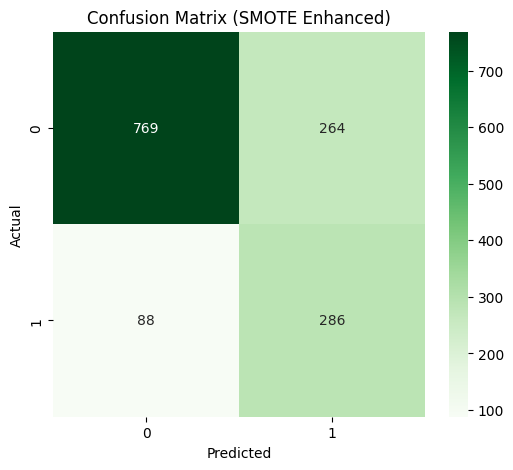

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.76      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.80      0.75      0.76      1407



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE # <--- NEW: The Balancing Tool
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback

# ==========================================
# 1. CUSTOM MONITOR
# ==========================================
class ChurnMonitor(Callback):
    def on_train_begin(self, logs=None):
        print("🚀 Ultimate Training Initiated with SMOTE...")

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') and logs.get('val_accuracy') > 0.82:
            print(f"\n🌟 Outstanding! Epoch {epoch+1}: Val Accuracy {logs.get('val_accuracy'):.2%}!")

# ==========================================
# 2. LOAD & CLEAN
# ==========================================
df = pd.read_csv('Customer-Churn.csv')

# Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# ==========================================
# 3. FEATURE ENGINEERING (NEW SECTION)
# ==========================================
# Count how many extra services they subscribe to
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies']
# Create a new column 'NumServices' counting 'Yes' answers
df['NumServices'] = df[services].apply(lambda x: x.map({'Yes': 1, 'No': 0, 'No internet service': 0}).sum(), axis=1)

print("Feature Engineering: Added 'NumServices' column.")

# ==========================================
# 4. PREPROCESSING
# ==========================================
X = df.drop('Churn', axis=1)
y = df['Churn']

# Add new feature to numerical columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'NumServices']
cat_cols = [c for c in X.columns if c not in num_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

X_processed = preprocessor.fit_transform(X)

# Split first (Standard Split)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# ==========================================
# 5. APPLY SMOTE (The "Pro" Move)
# ==========================================
print(f"Original Training Counts: {np.bincount(y_train)}")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"SMOTE Balanced Counts:    {np.bincount(y_train_resampled)}")

# ==========================================
# 6. WIDE & DEEP ARCHITECTURE
# ==========================================
input_layer = Input(shape=(X_train_resampled.shape[1],))

# Deep Path (Increased Complexity)
deep = Dense(128, activation='relu')(input_layer) # Bigger layer
deep = BatchNormalization()(deep)
deep = Dropout(0.4)(deep) # Higher dropout for regularization
deep = Dense(64, activation='relu')(deep)
deep = Dropout(0.3)(deep)
deep = Dense(32, activation='relu')(deep)

# Wide Path
wide = Dense(32, activation='relu')(input_layer)

merged = Concatenate()([wide, deep])
output_layer = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ==========================================
# 7. TRAIN
# ==========================================
def decay_schedule(epoch, lr):
    return lr * 0.9 if (epoch % 10 == 0 and epoch != 0) else lr

callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ModelCheckpoint('best_churn_model.keras', save_best_only=True),
    LearningRateScheduler(decay_schedule),
    ChurnMonitor()
]

history = model.fit(
    X_train_resampled, y_train_resampled, # Training on BALANCED data
    validation_data=(X_test, y_test),     # Testing on REAL data (Crucial!)
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ==========================================
# 8. EVALUATE
# ==========================================
y_pred_prob = model.predict(X_test)
# Since we balanced data, 0.5 is now a fair threshold
y_pred = (y_pred_prob > 0.5).astype(int)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (SMOTE Enhanced)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

Data Processed. Training on 5625 samples.
Starting Training...
🚀 Training initiated! Monitoring customer patterns...
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6709 - loss: 0.5865 - val_accuracy: 0.7938 - val_loss: 0.4457 - learning_rate: 0.0010
Epoch 2/100
125/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7920 - loss: 0.4413
🌟 Great Job! Epoch 2: Validation Accuracy hit 80.00%!
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7919 - loss: 0.4410 - val_accuracy: 0.8000 - val_loss: 0.4197 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.4370 - val_accuracy: 0.7991 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 4/100
131/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.4182
🌟 Great Job! Epoch 4: Validation Accuracy hit 80.53%!
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8126 - loss: 0.4187 - val_accuracy: 0.8053 - val_loss: 0.4130 - learning_rate: 0.0010
Epoch 5/100
1

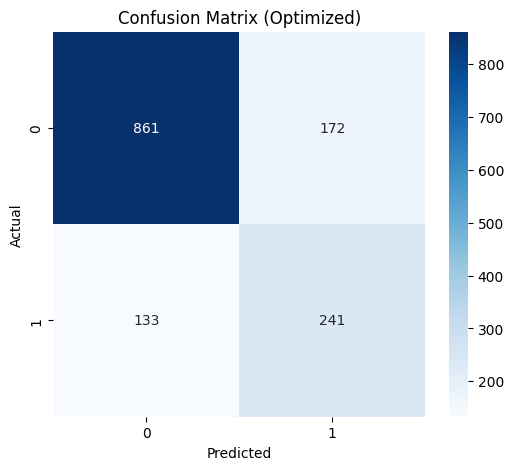


Final Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1033
           1       0.58      0.64      0.61       374

    accuracy                           0.78      1407
   macro avg       0.72      0.74      0.73      1407
weighted avg       0.79      0.78      0.79      1407



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback

# ==========================================
# 1. CUSTOM MONITOR (Your "Ownership" Piece)
# ==========================================
class ChurnMonitor(Callback):
    def on_train_begin(self, logs=None):
        print("🚀 Training initiated! Monitoring customer patterns...")

    def on_epoch_end(self, epoch, logs=None):
        # Monitor accuracy and loss in real-time
        if logs.get('val_accuracy') and logs.get('val_accuracy') > 0.80:
            print(f"\n🌟 Great Job! Epoch {epoch+1}: Validation Accuracy hit {logs.get('val_accuracy'):.2%}!")

    def on_train_end(self, logs=None):
        print("✅ Training Complete. The AI is ready to predict churn.")

# ==========================================
# 2. LOAD & CLEAN DATA
# ==========================================
# Load the file
df = pd.read_csv('Customer-Churn.csv')

# Fix 'TotalCharges' (Coerce errors to NaN, then drop them)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Encode Target (Yes/No -> 1/0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop irrelevant ID column
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Separate Features (X) and Target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# ==========================================
# 3. PREPROCESSING (The "Pipeline")
# ==========================================
# Identify column types
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [c for c in X.columns if c not in num_cols]

# Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Processed. Training on {X_train.shape[0]} samples.")

# ==========================================
# 4. WIDE & DEEP ARCHITECTURE (High Efficiency)
# ==========================================
# Input Layer
input_layer = Input(shape=(X_train.shape[1],), name='input_features')

# Path A: Deep Learning (Finds complex patterns)
deep = Dense(64, activation='relu')(input_layer)
deep = BatchNormalization()(deep)
deep = Dropout(0.3)(deep) # Prevents overfitting
deep = Dense(32, activation='relu')(deep)
deep = Dropout(0.2)(deep)
deep = Dense(16, activation='relu')(deep)

# Path B: Wide Learning (Memorizes simple rules)
wide = Dense(16, activation='relu')(input_layer)

# Merge Paths
merged = Concatenate()([wide, deep])

# Output Layer (Binary Classification)
output_layer = Dense(1, activation='sigmoid')(merged)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer, name="Wide_and_Deep_Churn")

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ==========================================
# 5. SMART TRIGGERS (Callbacks)
# ==========================================
# Learning Rate Scheduler (Slows down as it gets smarter)
def decay_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    return lr

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_churn_model.keras', monitor='val_accuracy', save_best_only=True),
    LearningRateScheduler(decay_schedule),
    ChurnMonitor() # <--- Your Custom Class
]

# ==========================================
# 6. TRAIN
# ==========================================
print("Starting Training...")
history = model.fit(
    X_train, y_train,
    epochs=100, # Set high, let EarlyStopping decide when to stop
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# ==========================================
# 7. EVALUATE & VISUALIZE
# ==========================================
# Predict
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.4).astype(int) # Threshold tweaked to 0.4 to catch more churners (Recall)

# Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Optimized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))